In [1]:
import scripts.data_preparation as dp
import rnn_model as rnn

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [3]:
sentiment_data = dp.data_loader()
sentiment_data = dp.data_preprocessor(sentiment_data)

In [4]:
# Test the different data preprocessing methods
columns = ['tokenized_text', 'no_punctuation_text', 'no_stopwords_text', 'stemmed_text', 'lemmatized_text']
results = []
for column in columns:
    model_result = rnn.train_and_evaluate(sentiment_data, column)
    results.append(model_result)

Epoch 1/20
254/254 [==============================] - 124s 454ms/step - loss: 14.8548 - val_loss: 8.6292
Epoch 2/20
254/254 [==============================] - 113s 446ms/step - loss: 6.1362 - val_loss: 4.0905
Epoch 3/20
254/254 [==============================] - 125s 494ms/step - loss: 2.8534 - val_loss: 1.8810
Epoch 4/20
254/254 [==============================] - 116s 457ms/step - loss: 1.3061 - val_loss: 0.8546
Epoch 5/20
254/254 [==============================] - 106s 416ms/step - loss: 0.5974 - val_loss: 0.3972
Epoch 6/20
254/254 [==============================] - 113s 447ms/step - loss: 0.2834 - val_loss: 0.1980
Epoch 7/20
254/254 [==============================] - 104s 408ms/step - loss: 0.1501 - val_loss: 0.1136
Epoch 8/20
254/254 [==============================] - 107s 423ms/step - loss: 0.0953 - val_loss: 0.0811
Epoch 9/20
254/254 [==============================] - 106s 416ms/step - loss: 0.0744 - val_loss: 0.0693
Epoch 10/20
254/254 [==============================] - 103s 407

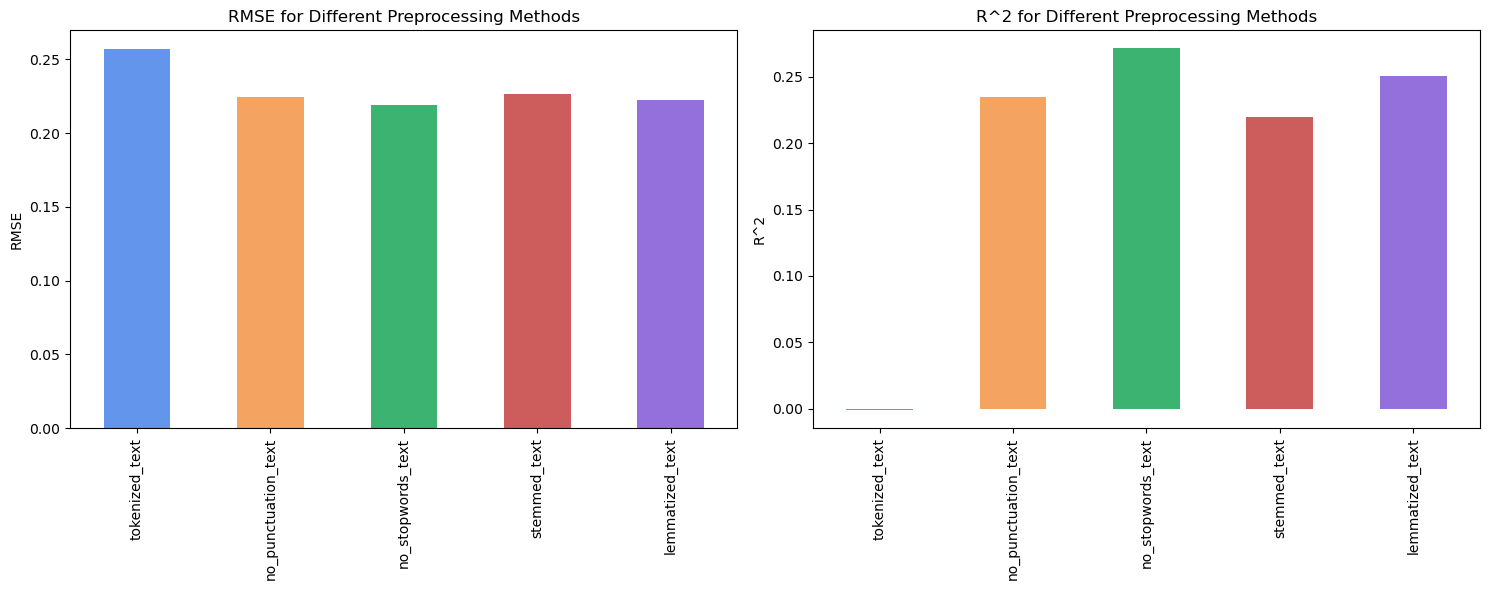

In [5]:
results_df = pd.DataFrame(results, columns=['RMSE', 'R^2'], index=columns)

# Create a list of colors
colors = ['cornflowerblue', 'sandybrown', 'mediumseagreen', 'indianred', 'mediumpurple']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot RMSE
results_df['RMSE'].plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('RMSE for Different Preprocessing Methods')
axes[0].set_ylabel('RMSE')

# Plot R^2
results_df['R^2'].plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('R^2 for Different Preprocessing Methods')
axes[1].set_ylabel('R^2')

plt.tight_layout()
plt.show()